In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
import jax
print(jax.devices())
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx 
from omegaconf import OmegaConf


import jax.numpy as jnp 
import matplotlib.pyplot as plt 
import numpy as np 

from utils_sgld import generate_data   
from examples.utils.sde import SDEIntegrator
from utils_sgld import build_OnsagerNetHD2



[CudaDevice(id=0)]


/home/aiqing/anaconda3/envs/jax/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Distribution comparison

(100, 2000, 4)
(100, 2000, 4)


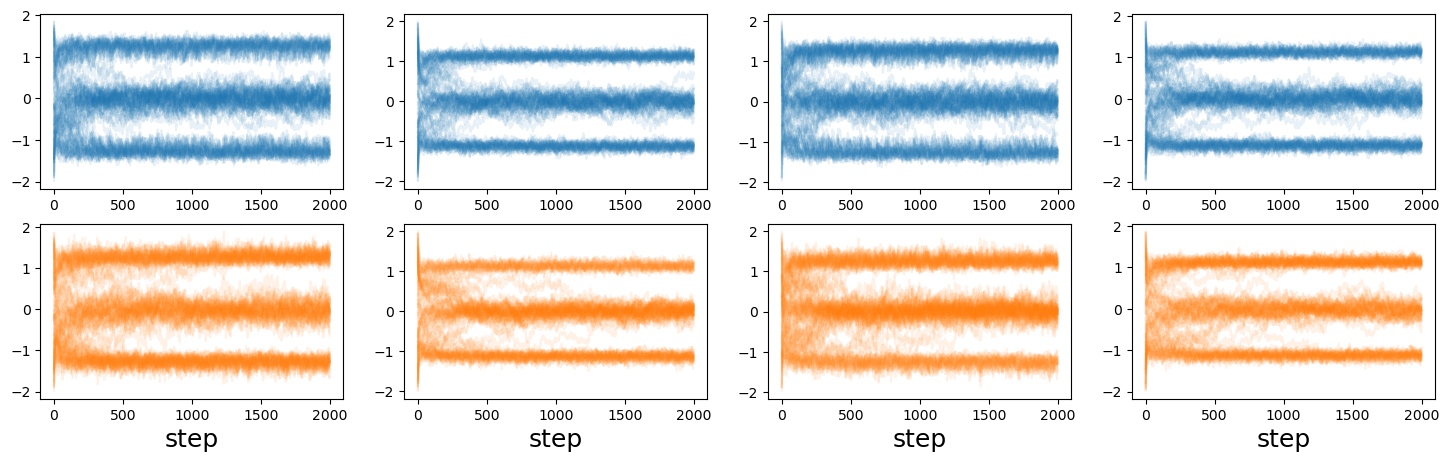

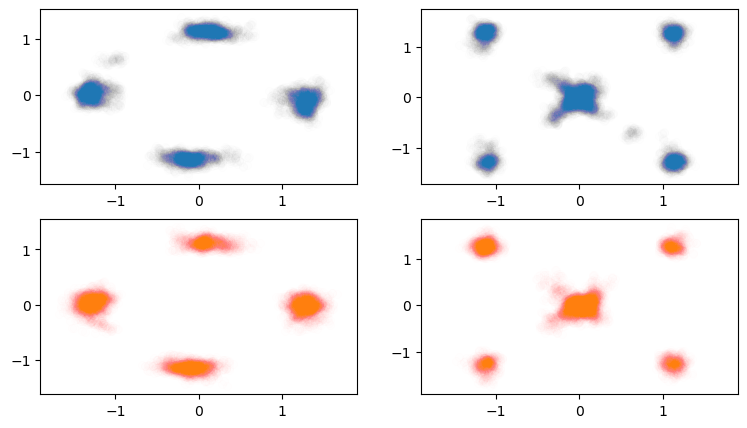

(100, 2000, 4)
(100, 2000, 4)


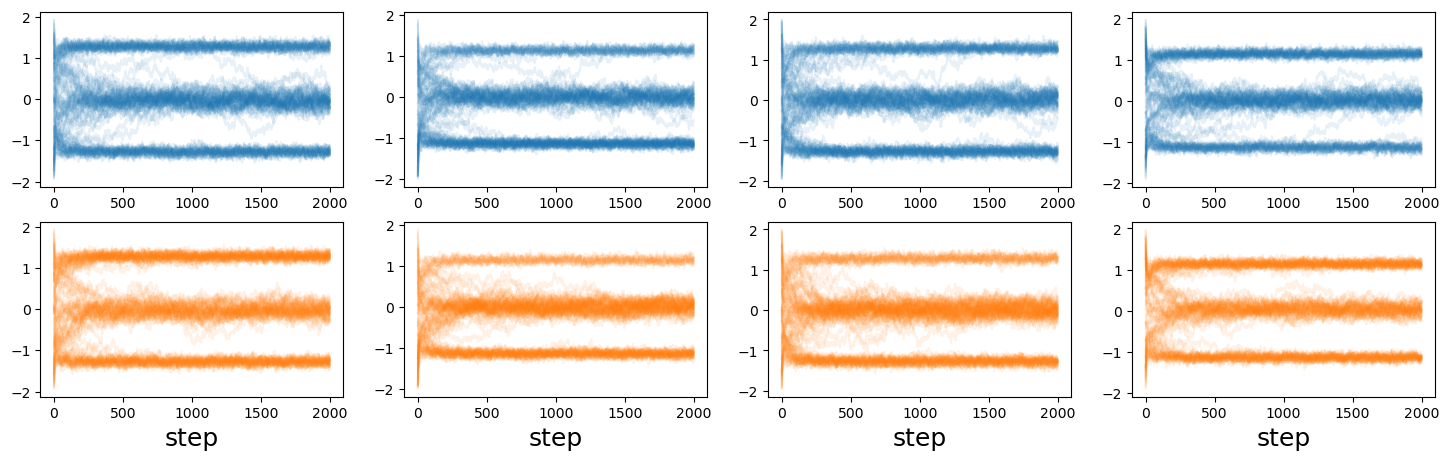

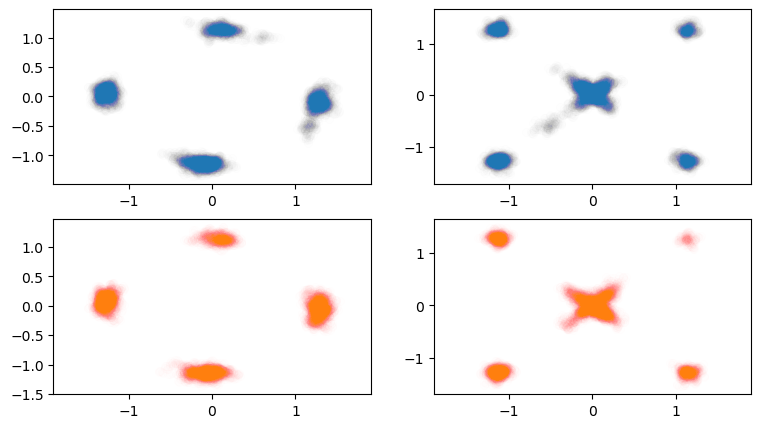

In [ ]:
def Distribution_comparison(batch_size, seed):

    total_seed=100
    max_iter=2000
    x_initial= np.random.uniform(size=(total_seed,4))*4-2


    data = generate_data(total_seed = total_seed, batch_size=batch_size, step=1, max_iter=max_iter,lr=0.05, W0=x_initial).with_format("jax")
    true_trajectories = data['x'][:,0].reshape(total_seed, max_iter, 4)


    path =  "outputs/main_res{}_HD2".format(seed)
    config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
    model_template = build_OnsagerNetHD2(config) 
    net = eqx.tree_deserialise_leaves(os.path.join(path,'batch_size_{}/model.eqx'.format(batch_size)), model_template)

    init_conditions = jnp.array(x_initial) 
    integrator = SDEIntegrator(model=net, state_dim=4)
    key = jr.PRNGKey(0) 
    bm_keys = jr.split(key, total_seed) 
    sol = integrator.parallel_solve(
        key=bm_keys,
        initial_conditions=init_conditions,
        t0=0.0,
        t1=int(0.05*max_iter),
        dt=0.05,
        args=[1],
    )
    predicted_trajectories = sol.ys

    print(true_trajectories.shape)
    print(predicted_trajectories.shape)

    fig, ax = plt.subplots(2,4, figsize=(18, 5))

    end=0
    for j in [0,1,2, 3]:
        for i in range(total_seed):
            ax[0, j].plot(true_trajectories[i,end:,j], color='C0', alpha=0.1)
            ax[1, j].plot(predicted_trajectories[i,end:,j], color='C1', alpha=0.1)
        ax[1, j].set_xlabel('step', fontsize=18)
        ax[0, j].set_rasterized(True)
        ax[1, j].set_rasterized(True)
    plt.show()
    fig.savefig('results/trajectory_batchsize_{}_seed_{}.svg'.format(batch_size, seed),bbox_inches='tight', pad_inches=0.1)

    fig, ax = plt.subplots(2,2, figsize=(9, 5))
    end=-100
    for j in [0,1]:
        ax[0, j].scatter(true_trajectories[:,end:,j], true_trajectories[:,end:,j+1], color='C0', alpha=0.005)
        ax[1, j].scatter(predicted_trajectories[:,end:,j],predicted_trajectories[:,end:,j+1], color='C1', alpha=0.005)
        ax[0, j].set_rasterized(True)
        ax[1, j].set_rasterized(True)
        ax[0, j].set_xlim([-1.9,1.9])
        ax[1, j].set_xlim([-1.9,1.9])
    plt.show()
    fig.savefig('results/distribution_batchsize_{}_seed_{}.svg'.format(batch_size, seed),bbox_inches='tight', pad_inches=0.1)



for b in [1, 64]:
    for seed in [10]:
        Distribution_comparison(batch_size=b, seed=seed)

EPR computation

In [ ]:
from utils_sgld import entropy_production_sgld

ep_list=[]
for b in [1,2, 4, 8,16,32,64]:
    ep_b_list=[]
    for seed in [10,20,30,40]:
        path = 'outputs/main_res{}_HD2'.format(seed)
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2(config) 
        net = eqx.tree_deserialise_leaves(os.path.join(path,'batch_size_{}/model.eqx'.format(b)), model_template)  
        ep, predicted_trajectories =  entropy_production_sgld(net, temperature=1.0, end_time=100.0, dt=0.05)
        ep_b_list.append(ep)
        print(b, ep)
    ep_list.append(ep_b_list)
ep_numpy=np.array(ep_list)
print("EPR \n", ep_numpy)


1 0.07340115
1 0.06389943
1 0.0680182
1 0.059588816
2 0.03127602
2 0.037134808
2 0.029587807
2 0.013780881
4 0.024455419
4 0.019880958
4 0.015062814
4 0.014033459
8 0.035760738
8 0.020116447
8 0.0065253936
8 0.015061718
16 0.011014938
16 0.015833799
16 0.0110287
16 0.033001333
32 0.019161228
32 0.015230414
32 0.018663146
32 0.009282707
64 0.017209418
64 0.007712103
64 0.012252077
64 0.010284716
EPR 
 [[0.07340115 0.06389943 0.0680182  0.05958882]
 [0.03127602 0.03713481 0.02958781 0.01378088]
 [0.02445542 0.01988096 0.01506281 0.01403346]
 [0.03576074 0.02011645 0.00652539 0.01506172]
 [0.01101494 0.0158338  0.0110287  0.03300133]
 [0.01916123 0.01523041 0.01866315 0.00928271]
 [0.01720942 0.0077121  0.01225208 0.01028472]]


In [ ]:

mean_ep = ep_numpy.mean(axis=1)
std_ep = ep_numpy.std(axis=1)

Distributaion difference between SGLD and full batch SGLD

In [ ]:
Data_deter=[]
from utils_sgld import generate_full_batch_data
total_seed=2000
max_iter=2000
batch_size=1
x_initial= np.random.uniform(size=(total_seed,4))*4-2
Data_all_batch=[]
for batch_size in [1,2,4,8,16,32,64]:
    data = generate_data(total_seed = total_seed, batch_size=batch_size, step=1, max_iter=max_iter,lr=0.05).with_format("jax")
    true_batch_trajectories = data['x'][:,0].reshape(total_seed, max_iter, 4)
    Data_all_batch.append(true_batch_trajectories)

full_batch_data = generate_full_batch_data(total_seed = total_seed,step=1, max_iter=max_iter,lr=0.05).with_format("jax")
true_full_batch_trajectories = full_batch_data['x'][:,0].reshape(total_seed, max_iter, 4)

In [ ]:
from sklearn.metrics import pairwise_kernels
end=10
num=2000
X_sampled = (np.array(true_full_batch_trajectories)[:num,-end:]).reshape(-1,4)
mmd1_values=[]
for i in range(len(Data_all_batch)):
    print(i)
    Y_sampled = (np.array(Data_all_batch[i])[:num,-end:]).reshape(-1,4) 
    # Computation of Gaussion kernal matrix for MMD
    gamma = 1.0
    XX = pairwise_kernels(X_sampled, X_sampled, metric='rbf', gamma=gamma)
    YY = pairwise_kernels(Y_sampled, Y_sampled, metric='rbf', gamma=gamma)
    XY = pairwise_kernels(X_sampled, Y_sampled, metric='rbf', gamma=gamma)

    # 计算MMD^2
    mmd_squared = XX.mean() + YY.mean() - 2 * XY.mean()
    print("MMD^2 1:", mmd_squared)
    mmd1_values.append(mmd_squared)


mmd2_values=[]
for i in range(len(Data_all_batch)-1):
    print(i)
    Y_sampled = (np.array(Data_all_batch[i])[:num,-end:]).reshape(-1,4)
    X_sampled = (np.array(Data_all_batch[i+1])[:num,-end:]).reshape(-1,4)
    # Computation of Gaussion kernal matrix for MMD
    gamma = 1.0
    XX = pairwise_kernels(X_sampled, X_sampled, metric='rbf', gamma=gamma)
    YY = pairwise_kernels(Y_sampled, Y_sampled, metric='rbf', gamma=gamma)
    XY = pairwise_kernels(X_sampled, Y_sampled, metric='rbf', gamma=gamma)

    # Computation of MMD^2
    mmd_squared = XX.mean() + YY.mean() - 2 * XY.mean()
    print("MMD^2 2:", mmd_squared)
    mmd2_values.append(mmd_squared)


0
MMD^2 1: 0.0017307102680206299
1
MMD^2 1: 0.001290351152420044
2
MMD^2 1: 0.001837030053138733
3
MMD^2 1: 0.00101393461227417
4
MMD^2 1: 0.0009550005197525024
5
MMD^2 1: 0.0004750937223434448
6
MMD^2 1: 0.0002912282943725586
0
MMD^2 2: 0.0013366937637329102
1
MMD^2 2: 0.0004998743534088135
2
MMD^2 2: 0.0004535466432571411
3
MMD^2 2: 0.0013739615678787231
4
MMD^2 2: 0.00044655799865722656
5
MMD^2 2: 0.0006395429372787476


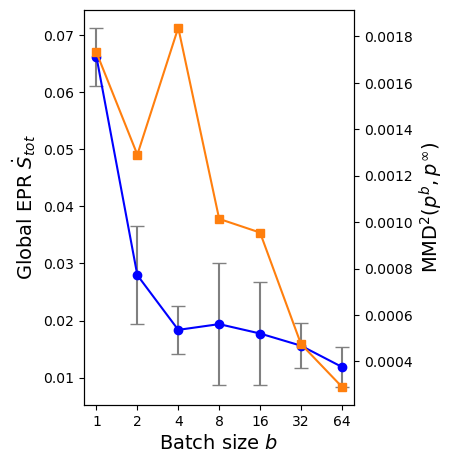

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 

# ---------- 
# Layout parameters (inches): 
# Fixing these ensures that the physical dimensions of the "true drawing area" do not change with the length of the data
# ----------
fig_size = (4.5,5)              # overall figure size in inches
left_margin_inch = 0.90
right_margin_inch = 0.90
bottom_margin_inch = 0.70
top_margin_inch = 0.35

label_fontsize = 14
tick_fontsize = 10

# relative fraction for add_axes
fig_w, fig_h = fig_size
left_frac = left_margin_inch / fig_w
right_frac = right_margin_inch / fig_w
bottom_frac = bottom_margin_inch / fig_h
top_frac = top_margin_inch / fig_h

width_frac = 1.0 - left_frac - right_frac
height_frac = 1.0 - bottom_frac - top_frac
if width_frac <= 0 or height_frac <= 0:
    raise ValueError("Margins are too large. Please reduce the margins or increase fig_Size.")

# ---------- PLOT----------
fig = plt.figure(figsize=fig_size, dpi=100)
ax1 = fig.add_axes([left_frac, bottom_frac, width_frac, height_frac])  # left, bottom, width, height (fractions)

# ---------- Left vertical axis: Entropy Production Rate ----------
x_ep = np.arange(1, len(mean_ep) + 1) 
ax1.errorbar(
    x_ep, mean_ep, yerr=std_ep,
    fmt='o-', capsize=5, color='b', ecolor='gray',
    label=r"Global EPR $\dot{S}_{tot}$"
)
ax1.set_xlabel(r"Batch size $b$", fontsize=label_fontsize)
ax1.set_ylabel(r"Global EPR $\dot{S}_{tot}$", fontsize=label_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

ax1.set_xticks(np.arange(1, 8))
ax1.set_xticklabels([1, 2, 4, 8, 16, 32, 64])

# ---------- Right vertical axis: MMD^2 ----------
ax2 = ax1.twinx()
x_mmd = np.arange(1, len(mmd1_values) + 1)
ax2.plot(
    x_mmd, mmd1_values,
    's-', color='C1', label='MMD$^2(p^b,p^{\infty})$'
)
ax2.set_ylabel('MMD$^2(p^b,p^{\infty})$', fontsize=label_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)


ax1.grid(False)
ax2.grid(False)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.savefig("results/error2.svg", dpi=300) 

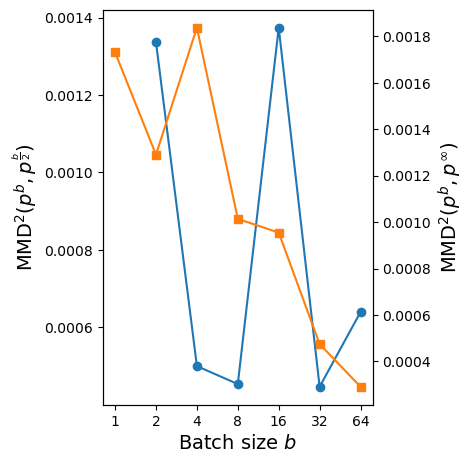

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 

# ---------- 
# Layout parameters (inches): 
# Fixing these ensures that the physical dimensions of the "true drawing area" do not change with the length of the data
# ----------
fig_size = (4.5,5)              # overall figure size in inches
left_margin_inch = 0.90
right_margin_inch = 0.90
bottom_margin_inch = 0.70
top_margin_inch = 0.35

label_fontsize = 14
tick_fontsize = 10

# relative fraction for add_axes
fig_w, fig_h = fig_size
left_frac = left_margin_inch / fig_w
right_frac = right_margin_inch / fig_w
bottom_frac = bottom_margin_inch / fig_h
top_frac = top_margin_inch / fig_h

width_frac = 1.0 - left_frac - right_frac
height_frac = 1.0 - bottom_frac - top_frac
if width_frac <= 0 or height_frac <= 0:
    raise ValueError("Margins are too large. Please reduce the margins or increase fig_Size.")

# ---------- PLOT ----------
fig = plt.figure(figsize=fig_size, dpi=100)
ax1 = fig.add_axes([left_frac, bottom_frac, width_frac, height_frac])  # left, bottom, width, height (fractions)

# ---------- Left vertical axis: MMD^2(b, b/2) ----------
x_mmd_d = np.arange(1, len(mmd2_values) + 1)+1
ax1.plot(
    x_mmd_d, mmd2_values,
    'o-', color='C0', label=r'MMD$^2(p^b,p^{\frac{b}{2}})$'
)
ax1.set_xlabel(r"Batch size $b$", fontsize=label_fontsize)
ax1.set_ylabel(r'MMD$^2(p^b,p^{\frac{b}{2}})$', fontsize=label_fontsize)
ax1.tick_params(axis='y', labelsize=tick_fontsize)
ax1.tick_params(axis='x', labelsize=tick_fontsize)

ax1.set_xticks(np.arange(1, 8))
ax1.set_xticklabels([1, 2, 4, 8, 16, 32, 64])

# ---------- Right vertical axis: MMD^2(b, \infty) ----------
ax2 = ax1.twinx()
x_mmd = np.arange(1, len(mmd1_values) + 1)
ax2.plot(
    x_mmd, mmd1_values,
    's-', color='C1', label='MMD$^2(p^b,p^{\infty})$'
)
ax2.set_ylabel('MMD$^2(p^b,p^{\infty})$', fontsize=label_fontsize)
ax2.tick_params(axis='y', labelsize=tick_fontsize)

ax1.grid(False)
ax2.grid(False)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.savefig("results/error_d_2.svg", dpi=300) 